In [2]:
%matplotlib inline
import numpy as np
from astropy.table import Table, hstack
import matplotlib.pyplot as plt

In [3]:
# Load tgas
data_tgas = Table.read('../tgas-source.fits')

In [4]:
# Put useful information in arrays
ls = data_tgas['l'].data
bs = data_tgas['b'].data
ras = data_tgas['ra'].data
decs = data_tgas['dec'].data
varpis = data_tgas['parallax'].data
varpierrs = data_tgas['parallax_error'].data
pm_ras = data_tgas['pmra'].data
pm_decs = data_tgas['pmdec'].data

In [5]:
# Define the v(r, alpha, delta) to v(x, y, z) matrix projection
# following Bovy, Hogg and Roweis 2009
def xyz_proj_matrix(alpha, delta):
    theta = 123 * np.pi/180
    alpha_NGP = 12.85 * np.pi/180
    delta_NGP = 27.7 * np.pi/180
    A1 = np.matrix([
            [np.cos(alpha), -np.sin(alpha), 0], 
            [np.sin(alpha), np.cos(alpha), 0],
            [0, 0, 1]
        ])
    A2 = np.matrix([
            [np.cos(delta), 0, -np.sin(delta)], 
            [0, 1, 1],
            [np.sin(delta), 0, np.cos(delta)]
        ])
    T1 = np.matrix([
            [np.cos(theta), np.sin(theta), 0], 
            [np.sin(theta), -np.cos(theta), 0],
            [0, 0, 1]
        ])
    T2 = np.matrix([
            [-np.sin(delta_NGP), 0, np.cos(delta_NGP)], 
            [0, 1, 1],
            [np.cos(delta_NGP), 0, np.sin(delta)]
        ])
    T3 = np.matrix([
            [np.cos(alpha_NGP), np.sin(alpha_NGP), 0], 
            [-np.sin(alpha_NGP), np.cos(alpha_NGP), 0],
            [0, 0, 1]
        ])
    T = np.dot(T1, np.dot(T2, T3))
    A = np.dot(A1, A2)
    R = np.dot(T, A)
    return R

# Invert it and discard v_r component
# Careful: this matrix must be multiplied by varpi
# in order to fully convert v(x, y, z) into PM(alpha, delta)
def xyz2pm(alpha, delta):
    k = 4.74047
    R = xyz_proj_matrix(alpha, delta)
    Rinv = np.linalg.inv(R)
    Rinv[1, :] /= k * np.cos(delta)
    Rinv[2, :] /= k
    return Rinv[1:, :]

In [6]:
# Adopt the first component of the velocity model of Bovy, Hogg, and Roweis (2009)
vxyz_mu = np.array([5.5, -6.9, -9.2])
vxyz_covar = np.matrix([[700, -110, 60],[-110, 200, 25],[60, -110, 143]])
    
# Compute the mean and variance of this model on a ra-dec-varpi grid
# We will compare this to the data
ra_grid = np.linspace(0, 360, 20)
dec_grid = np.linspace(-50, 50, 20)
varpi_grid = np.linspace(1, 4, 10)
pm_radec_grid_mean = np.zeros((ra_grid.size, dec_grid.size, varpi_grid.size, 2))
pm_radec_grid_covar = np.zeros((ra_grid.size, dec_grid.size, varpi_grid.size, 2, 2))
for i, ra in enumerate(ra_grid):
    for j, dec in enumerate(dec_grid):
        for k, varpi in enumerate(varpi_grid):
            delta = np.pi/180. * dec
            alpha = np.pi/180. * ra
            xyz2radec = xyz2pm(alpha, delta)
            pm_radec_grid_mean[i, j, k, :] = varpi * np.dot(xyz2radec, vxyz_mu)
            pm_radec_grid_covar[i, j, k, :, :] = varpi**2 * np.dot(xyz2radec, np.dot(vxyz_covar, xyz2radec.T))
            

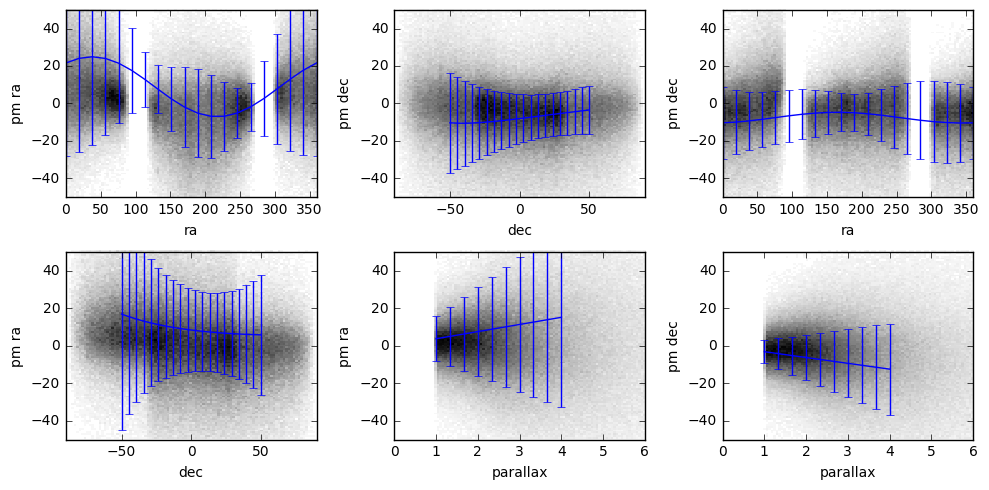

In [7]:
# Let's plot our data and the model
ind = np.abs(bs) > 30.
ind &= varpis > 1
ind &= varpis < 6

cmap = plt.cm.Greys # CMRmap #coolwarm# YlGnBu_r
cmap.set_gamma(0.5)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
v = 50
nbins = 100
axs[0].hist2d(ras[ind], pm_ras[ind], nbins, cmap=cmap, range=[[0, 360], [-v, v]])
y = pm_radec_grid_mean[:, :, :, 0].mean(axis=(1, 2))
yerr = pm_radec_grid_covar[:, :, :, 0, 0].mean(axis=(1, 2))**0.5
axs[0].errorbar(ra_grid, y, yerr)
axs[0].set_xlabel('ra')
axs[0].set_ylabel('pm ra')
y = pm_radec_grid_mean[:, :, :, 1].mean(axis=(0, 2))
yerr = pm_radec_grid_covar[:, :, :, 1, 1].mean(axis=(0, 2))**0.5
axs[1].hist2d(decs[ind], pm_decs[ind], nbins, cmap=cmap, range=[[-90, 90], [-v, v]])
axs[1].errorbar(dec_grid, y, yerr)
axs[1].set_xlabel('dec')
axs[1].set_ylabel('pm dec')
y = pm_radec_grid_mean[:, :, :, 1].mean(axis=(1, 2))
yerr = pm_radec_grid_covar[:, :, :, 1, 1].mean(axis=(1, 2))**0.5
axs[2].hist2d(ras[ind], pm_decs[ind], nbins, cmap=cmap, range=[[0, 360], [-v, v]])
axs[2].errorbar(ra_grid, y, yerr)
axs[2].set_xlabel('ra')
axs[2].set_ylabel('pm dec')
y = pm_radec_grid_mean[:, :, :, 0].mean(axis=(0, 2))
yerr = pm_radec_grid_covar[:, :, :, 0, 0].mean(axis=(0, 2))**0.5
axs[3].hist2d(decs[ind], pm_ras[ind], nbins, cmap=cmap, range=[[-90, 90], [-v, v]])
axs[3].errorbar(dec_grid, y, yerr)
axs[3].set_xlabel('dec')
axs[3].set_ylabel('pm ra')
y = pm_radec_grid_mean[:, :, :, 0].mean(axis=(0, 1))
yerr = pm_radec_grid_covar[:, :, :, 0, 0].mean(axis=(0, 1))**0.5
axs[4].hist2d(varpis[ind], pm_ras[ind], nbins, cmap=cmap, range=[[0, 6], [-v, v]])
axs[4].errorbar(varpi_grid, y, yerr)
axs[4].set_xlabel('parallax')
axs[4].set_ylabel('pm ra')
y = pm_radec_grid_mean[:, :, :, 1].mean(axis=(0, 1))
yerr = pm_radec_grid_covar[:, :, :, 1, 1].mean(axis=(0, 1))**0.5
axs[5].hist2d(varpis[ind], pm_decs[ind], nbins, cmap=cmap, range=[[0, 6], [-v, v]])
axs[5].errorbar(varpi_grid, y, yerr)
axs[5].set_xlabel('parallax')
axs[5].set_ylabel('pm dec')
fig.tight_layout()
fig.savefig('joint_varpi_pm_likelihood_bovyhoggroweis_prior.png', dpi=200)

In [12]:
# Define the new parallax likelihood, exploiting the covariance with proper motions!
# This has the true velocity marginalized over, with a gaussian mixture prior
def margLike( # This is for *one* star
    varpigrid, # varpi grid to compute the likelihood on
    pm_ra, pm_dec, varpi,  # data (point estimates)
    mu_varpi_covar, # data (covariance of the estimates)
    ra, dec, # position 
    vxyz_amps, vxyz_mus, vxyz_covars): # Gaussian mixture model (three lists containing arrays)

    assert mu_varpi_covar.shape[0] == 3 and mu_varpi_covar.shape[1] == 3
    n_comp = len(vxyz_amps) 
    assert len(vxyz_mus) == n_comp
    assert len(vxyz_covars) == n_comp
    for b in range(n_comp):
        assert vxyz_mus[b].size == 3
        assert vxyz_covars[b].shape[0] == 3 and vxyz_covars[b].shape[1] == 3

    xyz2radec = xyz2pm(np.pi/180 * ra,  np.pi/180 * dec)

    newlikeevals = 0*varpigrid # likelihood evaluated on varpi grid
    for b in range(n_comp): # loop through the components of the miture
        muprior = np.dot(xyz2radec, vxyz_mus[b])
        delta = np.zeros((varpigrid.size, 3)) # model - data
        delta[:, 0] = varpigrid*muprior[0, 0] - pm_ra
        delta[:, 1] = varpigrid*muprior[0, 1] - pm_dec
        delta[:, 2] = varpigrid - varpi
        for k, v in enumerate(varpigrid): # loop through parallax values
            comp_covar = 1*mu_varpi_covar
            comp_covar[:2, :2] += v**2 * np.dot(xyz2radec, np.dot(vxyz_covars[b], xyz2radec.T))
            y = np.exp(-0.5*np.dot(delta[k, :], np.linalg.solve(comp_covar, delta[k, :].T)))
            newlikeevals[k] += vxyz_amps[b] / (2*np.pi)**1.5 / np.linalg.det(comp_covar)**0.5 * y

    return newlikeevals

In [13]:
# select disk-like stars
ind = np.abs(bs) > 30.
ind &= varpis > 1
ind &= varpis / varpierrs < 4
ind &= varpis / varpierrs > 0
sel = np.where(ind)[0]
np.random.shuffle(sel)
sel = sel[:10000] # smaller subset! this likelihood implementation is really slow... 
print(sel.size, ind.size)

10000 2057050


In [14]:
# our model, again from Bovy, Hogg and Roweis (2009)
vxyz_amps = [1]
vxyz_mus = [np.array([5.5, -6.9, -9.2])]
vxyz_covars = [np.matrix([[700, -110, 60],[-110, 200, 25],[60, -110, 143]])]

0.025496321065085273 sec per object


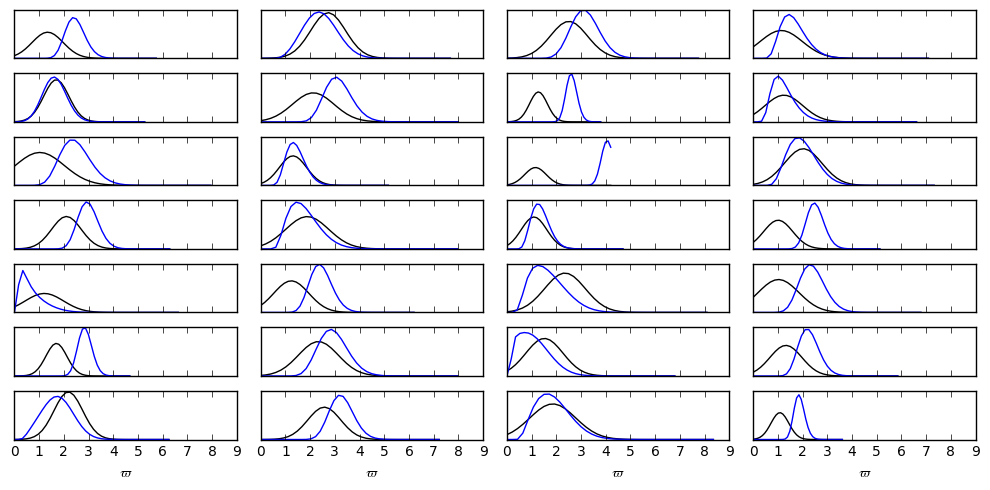

In [16]:
from time import time
fig, axs = plt.subplots(7, 4, sharex=True, figsize=(10, 5))
for i in range(axs.shape[1]):
    axs[-1, i].set_xlabel(r'$\varpi$')
axs = axs.ravel()
tmean = 0
for ii, idx in enumerate(sel[:axs.size]): 
    t1 = time()
    ra, dec = data_tgas[['ra', 'dec']][idx]
    pm_ra, pm_dec, varpi = data_tgas[['pmra', 'pmdec', 'parallax']][idx]
    sig_pmra = data_tgas['pmra_error'][idx]
    sig_pmdec = data_tgas['pmdec_error'][idx]
    sig_parallax = data_tgas['parallax_error'][idx]
    cov_pmra_varpi = data_tgas['parallax_pmra_corr'][idx] * sig_pmra * sig_parallax
    cov_pmdec_varpi = data_tgas['parallax_pmdec_corr'][idx] * sig_pmdec * sig_parallax
    cov_pmra_pmdec = data_tgas['pmra_pmdec_corr'][idx] * sig_pmra * sig_pmdec
    mu_varpi_covar = np.zeros((3, 3))
    mu_varpi_covar[0, :] = [sig_pmra**2, cov_pmra_pmdec, cov_pmra_varpi]
    mu_varpi_covar[1, :] = [cov_pmra_pmdec, sig_pmdec**2, cov_pmdec_varpi]
    mu_varpi_covar[2, :] = [cov_pmra_varpi, cov_pmdec_varpi, sig_parallax**2]
    
    sig = mu_varpi_covar[2, 2]**0.5
    vmin = np.max([0, varpi-7*sig])
    vmax = np.min([10, varpi+7*sig])
    varpigrid = np.linspace(vmin, vmax, 40)

    evals0 = np.exp(-0.5*((varpigrid-varpi)/sig)**2) / sig / np.sqrt(2*np.pi)
    
    evals1 = margLike(
        varpigrid,
        pm_ra, pm_dec, varpi, 
        mu_varpi_covar,
        ra, dec,
        vxyz_amps, vxyz_mus, vxyz_covars)
    
    evals0 /= np.trapz(evals0, x=varpigrid)
    evals1 /= np.trapz(evals1, x=varpigrid)
    t2 = time()
    
    tmean += (t2 - t1)/axs.size
    
    axs[ii].plot(varpigrid, evals0, c='k', lw=1)
    axs[ii].plot(varpigrid, evals1, c='b')
    axs[ii].set_yticks([])
fig.tight_layout()
print(tmean, "sec per object")
fig.savefig('joint_varpi_pm_likelihood_someobjects.png', dpi=200)

In [17]:
means = np.zeros((sel.size, 2)) # peak parallax without and with proper motions
peaks = np.zeros((sel.size, 2)) # mean parallax
stds = np.zeros((sel.size, 2)) # stddev parallax

fraction = sel.size // 100
print("Total:", sel.size)
print("Progression:", end=" ")
for ii, idx in enumerate(sel): 
    if ii / fraction == ii // fraction:
        print(ii, end=" ")
    ra, dec = data_tgas[['ra', 'dec']][idx]
    pm_ra, pm_dec, varpi = data_tgas[['pmra', 'pmdec', 'parallax']][idx]
    sig_pmra = data_tgas['pmra_error'][idx]
    sig_pmdec = data_tgas['pmdec_error'][idx]
    sig_parallax = data_tgas['parallax_error'][idx]
    cov_pmra_varpi = data_tgas['parallax_pmra_corr'][idx] * sig_pmra * sig_parallax
    cov_pmdec_varpi = data_tgas['parallax_pmdec_corr'][idx] * sig_pmdec * sig_parallax
    cov_pmra_pmdec = data_tgas['pmra_pmdec_corr'][idx] * sig_pmra * sig_pmdec
    mu_varpi_covar = np.zeros((3, 3))
    mu_varpi_covar[0, :] = [sig_pmra**2, cov_pmra_pmdec, cov_pmra_varpi]
    mu_varpi_covar[1, :] = [cov_pmra_pmdec, sig_pmdec**2, cov_pmdec_varpi]
    mu_varpi_covar[2, :] = [cov_pmra_varpi, cov_pmdec_varpi, sig_parallax**2]
    
    sig = mu_varpi_covar[2, 2]**0.5
    vmin = np.max([0, varpi-7*sig])
    vmax = np.min([10, varpi+7*sig])
    varpigrid = np.linspace(vmin, vmax, 20)

    evals0 = np.exp(-0.5*((varpigrid-varpi)/sig)**2) / sig / np.sqrt(2*np.pi)
    
    evals1 = margLike(
        varpigrid,
        pm_ra, pm_dec, varpi, 
        mu_varpi_covar,
        ra, dec,
        vxyz_amps, vxyz_mus, vxyz_covars)
    
    means[ii, 0] = np.average(varpigrid, weights=evals0)
    means[ii, 1] = np.average(varpigrid, weights=evals1)
    peaks[ii, 0] = varpigrid[np.argmax(evals0)]
    peaks[ii, 1] = varpigrid[np.argmax(evals1)]
    stds[ii, 0] = np.average((varpigrid-means[ii, 0])**2, weights=evals0)**0.5
    stds[ii, 1] = np.average((varpigrid-means[ii, 1])**2, weights=evals1)**0.5

Total: 10000
Progression: 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 

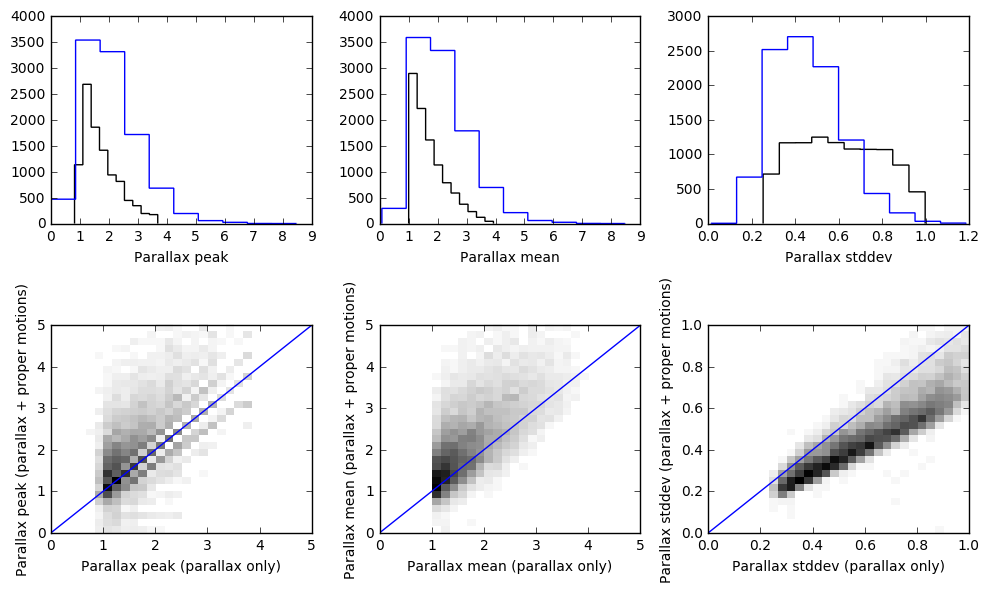

In [18]:

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.ravel()
axs[0].hist(peaks[:, 0], color='k', histtype='step')
axs[0].hist(peaks[:, 1], histtype='step')
axs[0].set_xlabel('Parallax peak')
axs[1].hist(means[:, 0], color='k', histtype='step')
axs[1].hist(means[:, 1], histtype='step')
axs[1].set_xlabel('Parallax mean')
axs[2].hist(stds[:, 0], color='k', histtype='step')
axs[2].hist(stds[:, 1], histtype='step')
axs[2].set_xlabel('Parallax stddev')
rr = [0, 5]
nbins = 30
axs[3].hist2d(peaks[:, 0], peaks[:, 1], nbins, range=[rr, rr], cmap="Greys")
axs[3].set_xlabel('Parallax peak (parallax only)')
axs[3].set_ylabel('Parallax peak (parallax + proper motions)')
axs[3].plot(rr, rr)
rr = [0, 5]
axs[4].hist2d(means[:, 0], means[:, 1], nbins, range=[rr, rr], cmap="Greys")
axs[4].set_xlabel('Parallax mean (parallax only)')
axs[4].set_ylabel('Parallax mean (parallax + proper motions)')
axs[4].plot(rr, rr)
rr =[0, 1]
axs[5].hist2d(stds[:, 0], stds[:, 1], nbins, range=[rr, rr], cmap="Greys")
axs[5].set_xlabel('Parallax stddev (parallax only)')
axs[5].set_ylabel('Parallax stddev (parallax + proper motions)')
axs[5].plot(rr, rr)
fig.tight_layout()

In [19]:
import dustmaps.bayestar
bayestar = dustmaps.bayestar.BayestarQuery(max_samples=2)

In [20]:
distances = (1000/varpis)
import astropy.units as units
from astropy.coordinates import SkyCoord
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ebv = bayestar(coords, mode='median')

B_RedCoeff = 3.626
V_RedCoeff = 2.742

/Users/bl/anaconda/lib/python3.5/site-packages/dustmaps/bayestar.py:249: RuntimeWarning: invalid value encountered in log10
  dm = 5. * (np.log10(d) + 2.)
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 672731 results
  RuntimeWarning)


In [21]:
data_apass = Table.read('../tgas-matched-apass-dr9.fits')
data_join = hstack((data_apass, data_tgas['source_id', 'l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']))
mag1 = data_join['vmag'] - ebv * V_RedCoeff
mag2 = data_join['bmag'] - ebv * B_RedCoeff
color = mag2[sel] - mag1[sel]
absmags0 = mag1[sel] + 5*np.log10(peaks[:, 0]) - 10
absmags1 = mag1[sel] + 5*np.log10(peaks[:, 1]) - 10
color_all = mag2 - mag1
absmags_all = mag1 + 5*np.log10(varpis) - 10

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


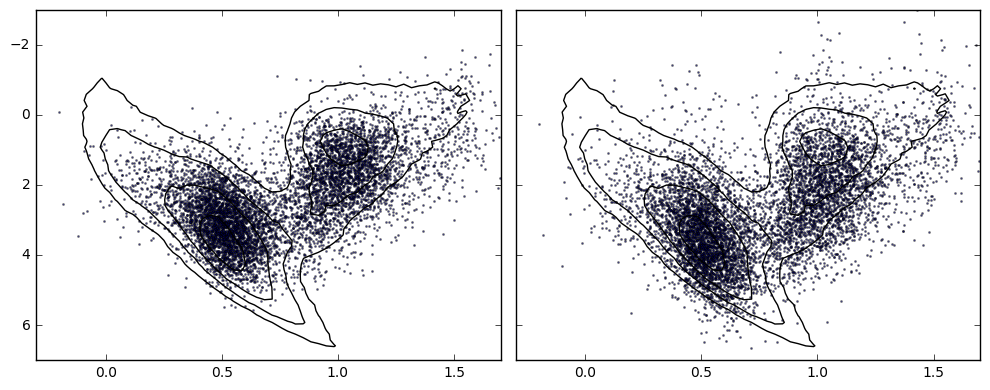

In [22]:
from corner import hist2d
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
therange = [[-0.3, 1.7], [-3, 7]]
nbins = 150
hist2d(color_all, absmags_all, bins=60, ax=axs[0], range=therange,
       plot_datapoints=False, plot_density=False, no_fill_contours=True)
hist2d(color_all, absmags_all, bins=60, ax=axs[1], range=therange,
       plot_datapoints=False, plot_density=False, no_fill_contours=True)
axs[0].scatter(color, absmags0, s=1, alpha=0.5)#, nbins, range=therange, cmap="Greys")
axs[1].scatter(color, absmags1, s=1, alpha=0.5)#, nbins, range=therange, cmap="Greys")
axs[0].set_ylim(therange[1][::-1])
fig.tight_layout()